In [1]:
import os
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rc('axes', labelsize=20)
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
import seaborn as sns


from sklearn.impute import KNNImputer
from fancyimpute import IterativeImputer as MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor



C:\Users\DELL\AppData\Local\Temp\ipykernel_19352\3648122014.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = (data.replace({'MONTH':{0: np.nan, " ":np.nan, " ":np.nan},


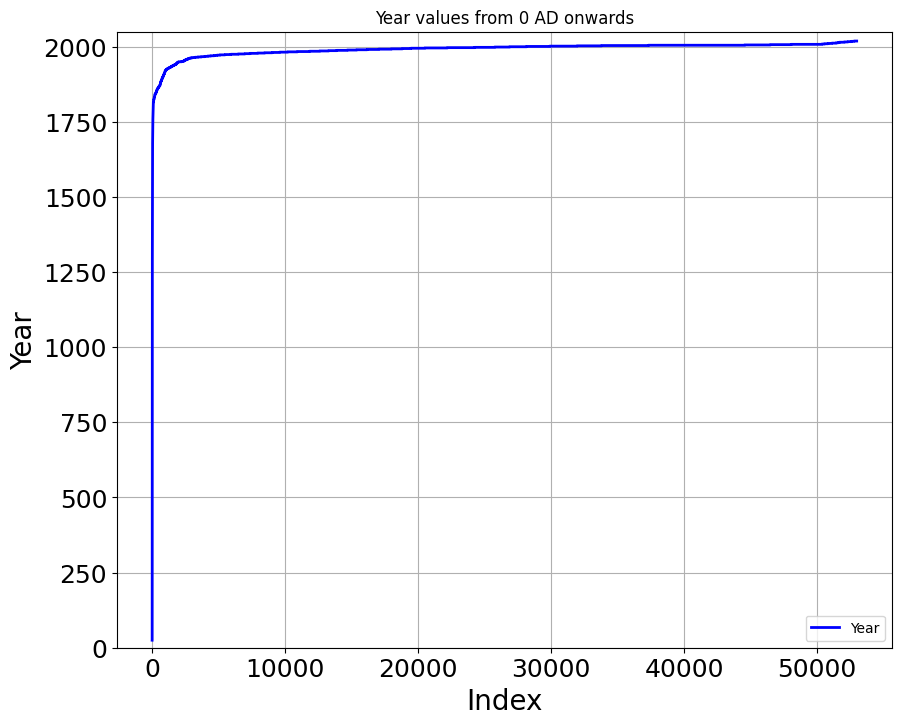

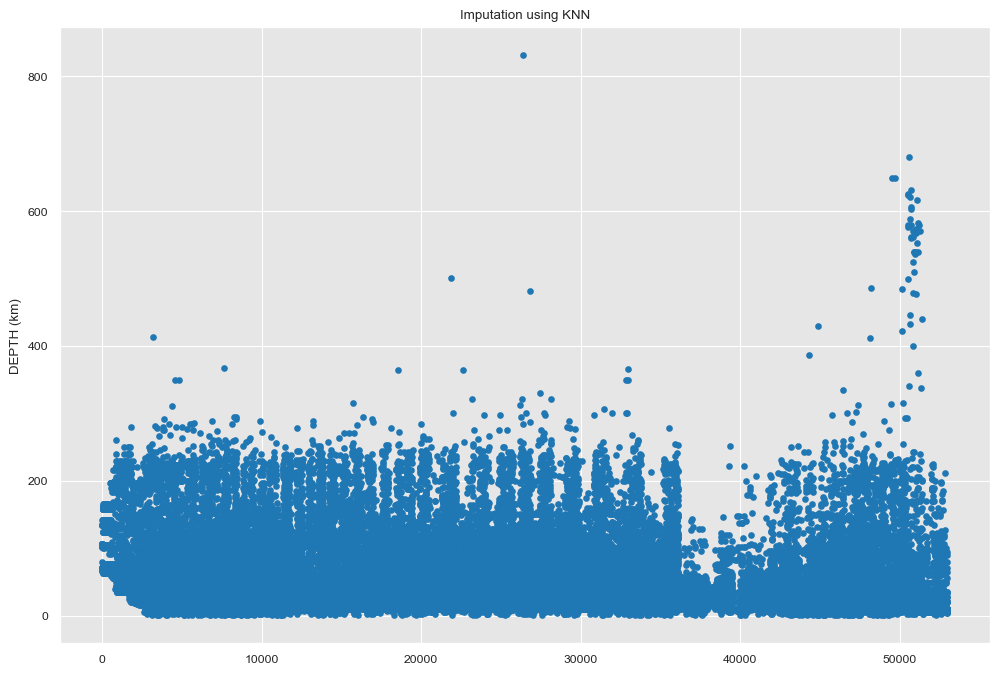

In [2]:
                                 # DATA PREPROCESSING

data = pd.read_excel('Indian earthquakes.xls')
data = data.iloc[8:, :]




# Renaming the columns
lst_colnames = []; dict_ctr = {}
for val1, val2 in zip(data.iloc[0, :].to_dict().values(), data.iloc[1, :].to_dict().values()):
    if pd.notna(val2):
        if pd.notna(val1):
            dict_ctr[val1.strip() + "-" + val2.strip()] = 0
            lst_colnames.append(val1.strip() + "-" + val2.strip())
        else:
            to_be_added = (lst_colnames[-1].split("-")[0]).strip() + "-" + val2.strip()
            if to_be_added not in lst_colnames:
                dict_ctr[to_be_added] = 0
                lst_colnames.append(to_be_added)
            else:
                dict_ctr[to_be_added] += 1
                lst_colnames.append(to_be_added + str(dict_ctr[to_be_added]))
    else:
        lst_colnames.append(val1.strip())
data = data.iloc[2:,:]
data.columns = lst_colnames


# DATA CLEANING
label = data['MAGNITUDE-Mw1']
data.drop(columns = ['INTENSITY-MME', 
                     'INTENSITY-MMI', 
                     'INTENSITY-MM', 
                     'ORIGIN TIME-(IST)', 
                     'LOCATION', 
                     'MAGNITUDE-Mb', 
                     'ORIGIN TIME-(UTC)', 
                     'MAGNITUDE-Mw', 
                     'MAGNITUDE-Mw1', 
                     'MAGNITUDE-Mb1', 
                     'REFERENCE', 
                     'MAGNITUDE-Ms', 
                     'MAGNITUDE-ML', 
                     'Sl. No.'], inplace = True)




data = (data.replace({'MONTH':{0: np.nan, " ":np.nan, " ":np.nan}, 
                      'DATE':{0: np.nan, " ":np.nan, " ":np.nan}})).iloc[2:, :]
data.reset_index(drop = True, inplace = True)

pd.set_option('future.no_silent_downcasting', True)


# Plotting the year 
plt.figure(figsize = (10,8))
plt.plot(np.arange(0, len(data)), data.YEAR, color = 'b', linestyle = '-', linewidth = 2, label = 'Year')
plt.ylabel("Year"); plt.xlabel("Index"); plt.ylim(0, 2050); plt.title("Year values from 0 AD onwards")
plt.grid(); plt.legend(); plt.show()





def month_date_imputer(df_mm_dd_yy):
    if pd.isna(df_mm_dd_yy.iloc[0,:].MONTH):
        df_mm_dd_yy.iloc[0,:].MONTH = 1
    if pd.isna(df_mm_dd_yy.iloc[0,:].DATE):
        df_mm_dd_yy.iloc[0,:].DATE = 1
    prev_row = df_mm_dd_yy.iloc[0,:]
    for row in (df_mm_dd_yy[df_mm_dd_yy['MONTH'].isnull()]).itertuples():
        cur_row, prev_row = df_mm_dd_yy.iloc[row.Index, :], df_mm_dd_yy.iloc[row.Index - 1, :]
        if cur_row.YEAR == prev_row.YEAR:
            if cur_row.MONTH == 12:
                df_mm_dd_yy.loc[row.Index, "MONTH"] = 12
            else:
                df_mm_dd_yy.loc[row.Index, "MONTH"] = prev_row.MONTH + 1
        else:
            df_mm_dd_yy.loc[row.Index, "MONTH"] = 1
    for row in (df_mm_dd_yy[df_mm_dd_yy['DATE'].isnull()]).itertuples():
        cur_row, prev_row = df_mm_dd_yy.iloc[row.Index, :], df_mm_dd_yy.iloc[row.Index - 1, :]
        if (cur_row.YEAR == prev_row.YEAR) and (cur_row.MONTH == prev_row.MONTH):
            if cur_row.DATE == 31:
                if cur_row.MONTH == 12:
                    df_mm_dd_yy.loc[row.Index] = np.array([cur_row.YEAR + 1, 1, 1])
                else: 
                    df_mm_dd_yy.loc[row.Index] = np.array([cur_row.YEAR, cur_row.MONTH + 1, 1])
            else:
                df_mm_dd_yy.loc[row.Index, "DATE"] = prev_row.DATE + 1
        else:
            df_mm_dd_yy.loc[row.Index, "DATE"] = 1
    return df_mm_dd_yy





pd.options.mode.chained_assignment = None
data[["YEAR", "MONTH", "DATE"]] = month_date_imputer(data[["YEAR", "MONTH", "DATE"]])
data = data.astype({"YEAR":"int32", "MONTH":"int32", "DATE":"int32"})


def to_numeric(x):
    try:
        return np.float32(x)
    except:
        return np.float32("".join([k for k in x if k not in ['N', 'S', chr(32), 'W', 'E', chr(176), chr(65392)]]))

data['LAT (N)'] = data['LAT (N)'].apply(to_numeric)
data['LONG (E)'] = data['LONG (E)'].apply(to_numeric)



# Cleaning and Imputing Depth Column
data = data.replace({"DEPTH (km)":{0:np.nan, " ":np.nan, "":np.nan}})


# KNN
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
data_transformed_KNN = imputer.fit_transform(data)
data_transformed_KNN = pd.DataFrame(data_transformed_KNN, columns = ['YEAR', 'MONTH', 'DATE', 'LAT (N)', 'LONG (E)', 'DEPTH (km)'])


plt.figure(figsize = (12,8))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("paper")
sns.scatterplot(x = np.arange(len(data_transformed_KNN)), y = data_transformed_KNN['DEPTH (km)'], linewidth = 0)
plt.title("Imputation using KNN"); plt.show()



# Using Regression Models
# Estimate the score after iterative imputation of the missing values
# with different estimators

estimators = [
    BayesianRidge(),
    ExtraTreesRegressor(n_estimators=50, random_state=0),
    RandomForestRegressor(n_estimators=50, random_state=0)
]
data_imputed_iterative = {}
estimator_names = ['bayesian_ridge', 'extra_trees_regressor', 'random_forest_regressor']
for name, impute_estimator in zip(estimator_names, estimators):
    data_imputed_iterative[name] = IterativeImputer(random_state=0, estimator=impute_estimator,
                                                    imputation_order='random').fit_transform(data.values)
    data_imputed_iterative[name] = pd.DataFrame(data_imputed_iterative[name], columns = ['YEAR', 
                                                                                         'MONTH', 
                                                                                         'DATE', 
                                                                                         'LAT (N)', 
                                                                                         'LONG (E)', 
                                                                                         'DEPTH (km)'])

# # Plot the depth profile...
# for name in estimator_names:
#     plt.figure(figsize = (12,8))
#     sns.scatterplot(x = np.arange(len(data_imputed_iterative[name])), 
#                     y = (data_imputed_iterative[name])["DEPTH (km)"], linewidth=0)#alpha = 0.7
#     plt.title(f"Iterative Imputation with {name} estimator.")
# plt.show()


# append the label column.
for key in data_imputed_iterative.keys():
    (data_imputed_iterative[key])['Magnitude'] = label
data_transformed_KNN['Magnitude'] = label


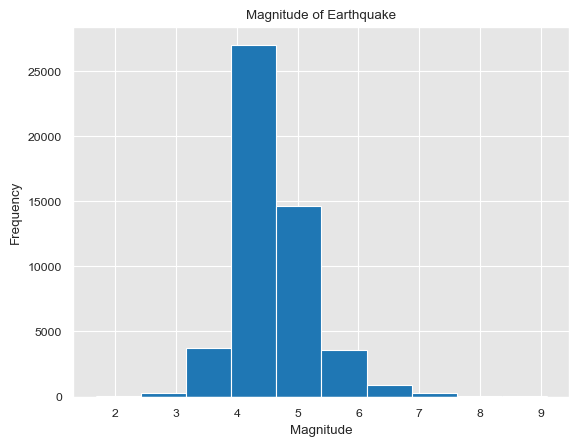

The Threshold for Magnitude that classify it as Earthquake and Non-Earthquake:  4.5532563999999995
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 21999, number of negative: 28471
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1005
[LightGBM] [Info] Number of data points in the train set: 50470, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.435883 -> initscore=-0.257889
[LightGBM] [Info] Start training from score -0.257889
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


magnitude = data_imputed_iterative['bayesian_ridge']['Magnitude'].dropna()
magnitude.hist()
plt.title("Magnitude of Earthquake")
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.show()



T = 0.387*(magnitude.max() - magnitude.min()) + magnitude.min()
print("The Threshold for Magnitude that classify it as Earthquake and Non-Earthquake: ", T)



train_val_dict, test_dict = {}, {}

for key in data_imputed_iterative.keys():
    train_val_dict[key] = data_imputed_iterative[key][data_imputed_iterative[key]['Magnitude'].notnull()].drop(columns = ["Unnamed: 0"], errors='ignore')
    
    test_dict[key] = data_imputed_iterative[key][data_imputed_iterative[key]['Magnitude'].isnull()].drop(columns = ["Unnamed: 0"], errors='ignore')

# Print to verify
# for key in train_val_dict.keys():
#     print(f"Training/Validation Data for {key}:")
#     print(train_val_dict[key].head())
    
# for key in test_dict.keys():
#     print(f"Test Data for {key}:")
#     print(test_dict[key].head())


                                                    # MODELS

def get_models():
    models_param = [{"n_neighbors": [50, 80, 120, 150, 180]}, 
                    {"max_depth": [3, 5, 7, 9, 11]}, 
                    {"n_estimators": [10, 25, 50, 100, 150]}]
    models = [KNeighborsClassifier(),
              DecisionTreeClassifier(random_state=23),
              LGBMClassifier(random_state = 23)
             ]
    return models, models_param

                                            # Evaluation

def evaluate_model(model, param_grid):
    cv = StratifiedKFold(n_splits=5, random_state=23, shuffle=True)
    return GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=1)



                              # TO EVALUATE DIFFERENT MODEL (TOTAL 9) 




final_results = {}
for data_key in train_val_dict.keys():
    models, models_param = get_models()
    
    final_results[data_key] = {}
    
    for model, param in zip(models, models_param):
        labels = (train_val_dict[data_key]["Magnitude"] >= T).astype(np.int32)
        
        if model.__class__.__name__ == "KNeighborsClassifier":
            data = train_val_dict[data_key].iloc[:, :-1].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
        else:
            data = train_val_dict[data_key].iloc[:, :-1]
        
        grid_model = evaluate_model(model, param)
        grid_result = grid_model.fit(data, labels)
        
        final_results[data_key][model.__class__.__name__] = grid_result

for data_key, results in final_results.items():
    print(f"Results for {data_key}:")
    for model_name, result in results.items():
        print(f"Model: {model_name}, Best Params: {result.best_params_}, Best Score: {result.best_score_}")




# From above result one can see that best is extraTreesRegressor with LGBMClassifier. So , we will use that.



